### *IPCC SR15 scenario assessment*

<img style="float: right; height: 80px; padding-left: 20px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="../_static/IAMC_logo.jpg">

# Analysis of carbon dioxide removal (CDR)

This notebook generates the assessment of carbon dioxide removal for **Figure 2.9** in the IPCC's _"Special Report on Global Warming of 1.5°C"_.

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

## Load `pyam` package and other dependencies

In [1]:
import pandas as pd
import numpy as np
import warnings
import io
import itertools
import yaml
import math
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('style_sr15.mplstyle')
%matplotlib inline
import pyam

<IPython.core.display.Javascript object>

## Import scenario data, categorization and specifications files

The metadata file must be generated from the notebook `sr15_2.0_categories_indicators` included in this repository.  
If the snapshot file has been updated, make sure that you rerun the categorization notebook.

The last cell of this section loads and assigns a number of auxiliary lists as defined in the categorization notebook.

In [2]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r1.1.xlsx')

INFO:root:Reading `../data/iamc15_scenario_data_world_r1.1.xlsx`


In [3]:
sr1p5.load_metadata('../data/sr15_metadata_indicators.xlsx')

INFO:root:Importing metadata for 416 scenarios (for total of 416)
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
with open("sr15_specs.yaml", 'r') as stream:
    specs = yaml.load(stream, Loader=yaml.FullLoader)

rc = pyam.run_control()
for item in specs.pop('run_control').items():
    rc.update({item[0]: item[1]})
cats = specs.pop('cats')
all_cats = specs.pop('all_cats')
subcats = specs.pop('subcats')
all_subcats = specs.pop('all_subcats')
plotting_args = specs.pop('plotting_args')
marker = specs.pop('marker')

## Downselect scenario ensemble to categories of interest for this assessment

In [5]:
df = sr1p5.filter(category=all_cats)

In [6]:
#df.data.iloc[:3]
df2 = sr1p5
type(df2.data)

pandas.core.frame.DataFrame

## Set specifications for filter and plotting

In [7]:
filter_args = dict(df=sr1p5, category=cats, marker=None, join_meta=True)

## Retrieve carbon dioxide emissions and generate two auxiliary variables with net-negative CO2 emissions 

For easier aggregation of the timeseries later on towards different metrics of carbon dioxide removal, we introduce both a positive net-negative timeseries (A, where the removal of 1Gt CO2 is counted as a positive value) and a timeseries where the sequestered amount is defined as a negative value (B).

In [8]:
co2 = df.filter(variable='Emissions|CO2').timeseries()

In [9]:
type(co2)
co2.columns

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2020, 2025, 2030, 2035, 2040, 2045,
            2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100],
           dtype='int64')

### A) Net-negative CO2 emissions

In [10]:
co2_nn = co2.applymap(lambda x: - min(x, 0)).reset_index()
co2_nn.variable = 'Emissions|CO2|Net-negative'

In [11]:
co2_nn_df = pyam.IamDataFrame(co2_nn)

In [12]:
df.data = df.data.append(co2_nn_df.data, ignore_index=True)

### B) Net-negative-negative CO2 emissions

In [13]:
co2_nn_neg = co2.applymap(lambda x: min(x, 0)).reset_index()
co2_nn_neg.variable = 'Emissions|CO2|Net-negative-negative'

In [14]:
co2_nn_neg_df = pyam.IamDataFrame(co2_nn_neg)

In [15]:
df.data = df.data.append(co2_nn_neg_df.data, ignore_index=True)

In [16]:
df.data.iloc[:3]

,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR5 climate diagnostics|Concentration|CO2|FAIR...,ppm,2010,389.102
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR5 climate diagnostics|Concentration|CO2|FAIR...,ppm,2011,391.579
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR5 climate diagnostics|Concentration|CO2|FAIR...,ppm,2012,394.117


## Retrieve carbon dioxide emissions from agriculture, forestry and land-use

In [17]:
co2_afolu = df.filter(variable='Emissions|CO2|AFOLU').timeseries()

In [18]:
co_afolu_nn = co2_afolu.applymap(lambda x: - min(x, 0)).reset_index()
co_afolu_nn.variable = 'Emissions|CO2|AFOLU|Net-negative'

In [19]:
co_afolu_nn_df = pyam.IamDataFrame(co_afolu_nn)

In [20]:
df.data = df.data.append(co_afolu_nn_df.data, ignore_index=True)

## Determine emissions reductions from land use

### Where possible, determine AFOLU CO2 emissions reduction relative to baseline

In [21]:
base_mapping = df.meta.reset_index()[['model', 'scenario', 'baseline']].groupby(['model'])

In [22]:
afolu_cdr_lst = []

for mapping in base_mapping:
    m = mapping[0]
    _df = co_afolu_nn_df.filter(model=m, year=range(2020, 2101))
    base_mapping_by_model = mapping[1].groupby(['baseline'])
    for _mapping in base_mapping_by_model:
        b = _mapping[0]
        base = _df.filter(scenario=b).timeseries()
        base.index = base.index.droplevel([1, 2, 3, 4])

        for s in _mapping[1].scenario:
            cdr = _df.filter(scenario=s).timeseries()
            cdr.index = cdr.index.droplevel([1, 2, 3, 4])
            cdr = cdr - base
            cdr['scenario'] = s
            afolu_cdr_lst.append(cdr)

In [23]:
afolu_cdr = pd.concat(afolu_cdr_lst, sort=False).reset_index()
afolu_cdr['region'] = 'World'
afolu_cdr['variable'] = 'Emissions|CO2|AFOLU|Net-negative reduction'
afolu_cdr['unit'] = 'MtCO2'

In [24]:
afolu_cdr_df = pyam.IamDataFrame(afolu_cdr)

### For scenarios that do not provide a baseline, use the self-reported land-iuse carbon sequestration timeseries

In [25]:
alofu_cdr_direct_df = df.filter(variable='Carbon Sequestration|Land Use',
                                scenario=['PEP*', 'IMA15*', 'LowEnergyDemand'],
                                year=range(2020, 2101)
                               )

### Check that methods 1 and 2 do not overlap, then merge

In [26]:
if not afolu_cdr_df.meta.index.intersection(alofu_cdr_direct_df.meta.index).empty:
    print('There is an overlap of index sets!')

In [27]:
afolu_cdr_df.data = afolu_cdr_df.data.append(alofu_cdr_direct_df.data, ignore_index=True)

## Remove 'Carbon Sequestration|Land Use' from `IamDataFrame` and merge in alternative metrics

In [28]:
df.filter(variable='Carbon Sequestration|Land Use', keep=False, inplace=True)

In [29]:
df.data = df.data.append(afolu_cdr_df.data, ignore_index=True)

In [30]:
df.rename({'variable': {'Carbon Sequestration|Land Use': 'AFOLU CDR',
                        'Emissions|CO2|AFOLU|Net-negative reduction': 'AFOLU CDR'}}, inplace=True)

In [31]:
exclude_no_afolue_cdr = df.require_variable('AFOLU CDR', exclude_on_fail=True)

INFO:root:82 scenarios do not include required variable `AFOLU CDR`, marked as `exclude: True` in metadata


In [32]:
df.filter(exclude=False, inplace=True)

## Rename variables for plots

In [33]:
variable_mapping = [
    ('Total CDR', [
        'Carbon Sequestration|CCS|Biomass',
        'AFOLU CDR',
        'Carbon Sequestration|Direct Air Capture',
        'Carbon Sequestration|Enhanced Weathering']),
    ('AFOLU CDR', 'AFOLU CDR'),
    ('BECCS', 'Carbon Sequestration|CCS|Biomass'),
    ('Net negative CO2', 'Emissions|CO2|Net-negative'),
    ('Compensate CDR', [
        'Carbon Sequestration|CCS|Biomass',
        'AFOLU CDR',
        'Carbon Sequestration|Direct Air Capture',
        'Carbon Sequestration|Enhanced Weathering',
        'Emissions|CO2|Net-negative-negative'])
]

In [34]:
valid_variables = []
for (name, variable) in variable_mapping:
    if pyam.isstr(variable):
        valid_variables.append(variable)
    else:
        for v in variable:
            valid_variables.append(v)

In [35]:
df.filter(variable=valid_variables, inplace=True)

In [36]:
df.data.iloc[:25]
# save to an excel file

df.data.to_csv('output/CCSBySource.csv')

## Plot by warming category with multiple last years

In [37]:
cats.remove('Above 2C')

In [38]:
def marker_args(m):
    return dict(zorder=4,
                edgecolors=rc['edgecolors']['marker'][m],
                c=rc['c']['marker'][m],
                marker=rc['marker']['marker'][m],
                linewidths=1)

In [75]:
def boxplot_cumulative_ccs(ymax, last_year, panel_label, legend=True): # should be able to include categories like this
    fig = plt.figure(figsize=(8, 3))

    _cats = len(cats) - 1
    label_list = []
    for i, (name, v) in enumerate(variable_mapping):
        _df = df.filter(variable=v, year=range(2020, 2101, 10)).timeseries() / 1000 # gigatons 
        _df = _df.groupby(['model', 'scenario']).sum()
        _df = pd.DataFrame(_df.apply(pyam.cumulative, raw=False, axis=1, first_year=2020, last_year=last_year))
        _df = pyam.filter_by_meta(_df, df, category=cats, marker=None, join_meta=True)

        for j, c in enumerate(cats):
            __df = _df[_df.category == c]
            
            lst = __df[0][~np.isnan(__df[0])]
            pos = 0.5 / _cats * (j - _cats / 2) + i

            outliers = len(lst[lst > ymax])
            if outliers > 0:
                plt.text(pos - 0.01 * len(cats), ymax * 1.01, outliers)

            p = plt.boxplot(lst, positions=[pos], widths=(0.3 / _cats),
                            whis='range',
                            patch_artist=True)
            plt.setp(p['boxes'], color=rc['color']['category'][c])
            plt.setp(p['medians'], color='black')

            for m in marker:
                val = __df.loc[_df.marker == m, 0]
                if not val.empty:
                    plt.scatter(x=pos, y=val, **marker_args(m),
                                s=40, label=None)

        label_list.append(name)

    for m in marker:
        meta = df.filter(marker=m).timeseries()
        if not meta.empty:
            meta = meta.iloc[0].name[0:2]
            plt.scatter(x=[], y=[], **marker_args(m), s=60, label=m)

    for j, c in enumerate(cats):
        plt.plot([], c=rc['color']['category'][c], label='{}'.format(c))

    if legend:
        plt.legend()

    plt.grid(False)
    plt.xlim(-0.6, (i + 0.6))
    plt.xticks(range(0, i + 1), label_list)
    plt.vlines(x=[_i + 0.5 for _i in range(i)], ymin=0, ymax=ymax, colors='white')
    plt.ylim(0, ymax)
    plt.ylabel('Cumulative CO2 until {} (GtCO2)'.format(last_year))

    fig.savefig('output/fig2.9{}_cdr_{}.png'.format(panel_label, last_year))

Total CDR ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering']
name Total CDR
v ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering']
(650, 9)
(334, 9)
(334, 1)
(209, 3)
AFOLU CDR AFOLU CDR
name AFOLU CDR
v AFOLU CDR
(334, 9)
(334, 9)
(334, 1)
(209, 3)
BECCS Carbon Sequestration|CCS|Biomass
name BECCS
v Carbon Sequestration|CCS|Biomass
(302, 9)
(302, 9)
(302, 1)
(188, 3)
Net negative CO2 Emissions|CO2|Net-negative
name Net negative CO2
v Emissions|CO2|Net-negative
(334, 9)
(334, 9)
(334, 1)
(209, 3)
Compensate CDR ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering', 'Emissions|CO2|Net-negative-negative']
name Compensate CDR
v ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|

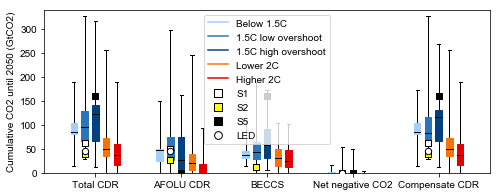

In [76]:
boxplot_cumulative_ccs(340, 2050, 'a')

Total CDR ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering']
name Total CDR
v ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering']
(650, 9)
(334, 9)
(334, 1)
(209, 3)
AFOLU CDR AFOLU CDR
name AFOLU CDR
v AFOLU CDR
(334, 9)
(334, 9)
(334, 1)
(209, 3)
BECCS Carbon Sequestration|CCS|Biomass
name BECCS
v Carbon Sequestration|CCS|Biomass
(302, 9)
(302, 9)
(302, 1)
(188, 3)
Net negative CO2 Emissions|CO2|Net-negative
name Net negative CO2
v Emissions|CO2|Net-negative
(334, 9)
(334, 9)
(334, 1)
(209, 3)
Compensate CDR ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|Enhanced Weathering', 'Emissions|CO2|Net-negative-negative']
name Compensate CDR
v ['Carbon Sequestration|CCS|Biomass', 'AFOLU CDR', 'Carbon Sequestration|Direct Air Capture', 'Carbon Sequestration|

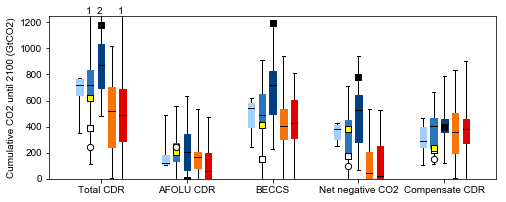

In [83]:
boxplot_cumulative_ccs(1250, 2100, 'b', legend=False)

## Export timeseries data to `xlsx`

In [84]:
variable_mapping

[('Total CDR',
  ['Carbon Sequestration|CCS|Biomass',
   'AFOLU CDR',
   'Carbon Sequestration|Direct Air Capture',
   'Carbon Sequestration|Enhanced Weathering']),
 ('AFOLU CDR', 'AFOLU CDR'),
 ('BECCS', 'Carbon Sequestration|CCS|Biomass'),
 ('Net negative CO2', 'Emissions|CO2|Net-negative'),
 ('Compensate CDR',
  ['Carbon Sequestration|CCS|Biomass',
   'AFOLU CDR',
   'Carbon Sequestration|Direct Air Capture',
   'Carbon Sequestration|Enhanced Weathering',
   'Emissions|CO2|Net-negative-negative'])]

In [85]:
cats

['Below 1.5C',
 '1.5C low overshoot',
 '1.5C high overshoot',
 'Lower 2C',
 'Higher 2C']

In [86]:
df.to_excel('output/fig2.9_data_table.xlsx')

In [113]:
def exportDataExcel(last_year): # should be able to include categories like this
    _cats = len(cats) - 1
    label_list = []
    
    for i, (name, v) in enumerate(variable_mapping):
        _df = df.filter(variable=v, year=range(2020, 2101, 5)).timeseries() / 1000
        _df = _df.groupby(['model', 'scenario']).sum()
        _df = pyam.filter_by_meta(_df, df, category=cats, marker=None, join_meta=True)

        for j, c in enumerate(cats):
            __df = _df[_df.category == c]
            __df.to_csv(('output/fig2.9_data_table' + name + c + '.csv'))

In [114]:
exportDataExcel(2100)

In [153]:
x = pd.read_csv(('output/fig2.9_data_tableTotal CDR1.5C low overshoot.csv'))
x['Variable'] = name
cols = x.columns
print(cols)

def combineData():
    a = pd.DataFrame(columns=cols)
    for i, (name, v) in enumerate(variable_mapping):
        for j, c in enumerate(cats):
            x = pd.read_csv(('output/fig2.9_data_table' + name + c + '.csv'))
            x['Variable'] = name
            a = pd.concat([a, x])
    print(a.shape)
    a = a.sort_values(['model', 'scenario'], ascending = (True, False))
    a.to_csv('output/CombinedCsvsWithOutcome.csv')

Index(['model', 'scenario', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100', 'category', 'marker', 'Variable'],
      dtype='object')


In [154]:
combineData()

(1024, 22)
